# Pseudo-biases with vector speed

Investigate pseudo-biases in vector speed / magnitude data. Pseudo-biases are biases that are not characteristics of the observations, but arise from the non-linear transformation from vector components to vector speed / magnitude.

Consider a vector field with components $(dX,dY)$. The true vector field is $T=(tX,tY)$, with observations $O=(oX,oY)$. $oX$ (resp. $oY$) are un-biased observations of $tX$ (resp. $tY$) with uncertainties $uX$ and $uY$.

We will see that, despite $oX$ and $oY$ being un-biased observations, the observed speed $oV = \sqrt{oX^2+oY^2}$ is biased *wrt* the true speed $tV = \sqrt{tX^2+tY^2}$.

Inspired / adapted from Appendix B of Stoffelen (1998).

Stoffelen, A. (1998), Toward the true near-surface wind speed: Error modeling and calibration using triple collocation, J. Geophys. Res., 103( C4), 7755– 7766, doi:10.1029/97JC03180.

In [1]:
import numpy as np
from numpy.random import default_rng
from matplotlib import pylab as plt
import matplotlib.lines as mlines

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
rng = default_rng()
N = 5000

def speed(dX, dY):
    return (dX**2 + dY**2)**0.5

## Illustration of the pseudo-bias

Define the (unknown) truth for $dX$, $dY$, and speed.

In [3]:
sig_t = 17.
tX = rng.standard_normal(N) * sig_t + 5.4
tY = rng.standard_normal(N) * sig_t + 2.1
tV = speed(tX, tY)

Define an un-biased observation of the truth, with uncertainties

In [4]:
# uncertain observations of dX
sig_ux = 10
ux = rng.standard_normal(N) * sig_ux
oX = tX + ux

# uncertain observations of dY
sig_uy = 10
uy = rng.standard_normal(N) * sig_uy
oY = tY + uy

# observation of the speed (derived from oX and oY)
oV = speed(oX, oY)

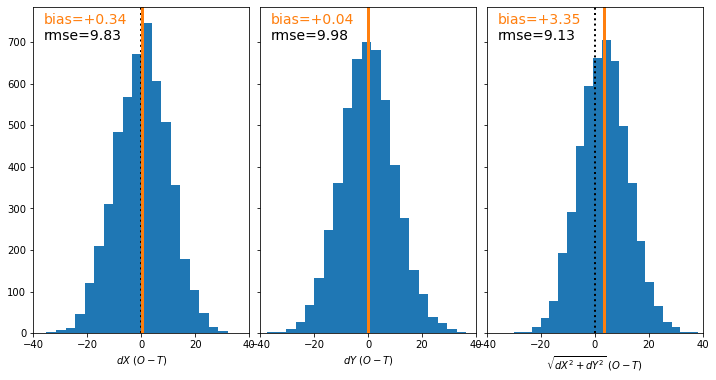

In [5]:

def plot_hist(ax, d, w, maxu):
    ax.hist(d, bins=21)
    ax.set_xlabel(w + r" $(O-T)$")
    ax.set_xlim(-maxu,+maxu)
    ax.axvline(x=0, color='k', ls=':', lw=2)
    bias = d.mean()
    rmse = d.std()
    ax.axvline(x=bias, color='C1', ls='-', lw=3)
    fs = 14
    ystep = 0.05
    ystart = 0.95
    ax.text(0.05,ystart,'bias={:+.2f}'.format(bias),transform=ax.transAxes, fontsize=fs, color='C1'); ystart -= ystep
    ax.text(0.05,ystart,'rmse={:.2f}'.format(rmse),transform=ax.transAxes, fontsize=fs); ystart -= ystep
    
maxu = 4*max(sig_ux,sig_uy)
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,3,1)
plot_hist(ax, oX - tX, r"$dX$", maxu)

ax = fig.add_subplot(1,3,2,sharey=ax)
plot_hist(ax, oY - tY, r"$dY$", maxu)
plt.setp(ax.get_yticklabels(), visible=False)

ax = fig.add_subplot(1,3,3,sharey=ax)
plot_hist(ax, oV - tV, r"$\sqrt{dX^2+dY^2}$", maxu)
plt.setp(ax.get_yticklabels(), visible=False)

plt.subplots_adjust(wspace=0.05)
plt.show()

We see that, although  $oX$  and  $oY$  are un-biased observations of $tX$ and $tY$, the resulting observed speed $oV$ (computed from $oX$ and $oY$) is biased *wrt* the true speed $tV$.

## Sensitivity of the pseudo-bias to the observation uncertainty
We repeat the experiment above, but this time vary the observation uncertainty in dX and dY to see how the pseudo-bias in speed evolves.

Define the truth $tX$, $tY$, and $tV$. It will be constant throughout this sensitivity study.

In [6]:
N = 100000
sig_t = 17.
tX = rng.standard_normal(N) * sig_t + 5.4
tY = rng.standard_normal(N) * sig_t + 2.1
tV = speed(tX, tY)

Iterate through a range of observation uncertainties (in both $dX$ and $dY$) and compute the corresponding pseudo-bias in speed.

In [7]:
max_sig = 1.5 * sig_t
num_sig = 15

In [8]:
sigs_ux = np.linspace(0.0, max_sig, num=num_sig)
sigs_uy = np.linspace(0.0, max_sig, num=num_sig)

# structure to store the biases
bias_X = np.empty((num_sig, num_sig))
bias_Y = np.empty((num_sig, num_sig))
bias_V = np.empty((num_sig, num_sig))

# loop through pairs of sig_ux, sig_uy
for iy, sig_uy in enumerate(sigs_uy):
    
    for ix, sig_ux in enumerate(sigs_ux):

        # uncertain observations of dX
        ux = rng.standard_normal(N) * sig_ux
        oX = tX + ux

        # uncertain observations of dY
        uy = rng.standard_normal(N) * sig_uy
        oY = tY + uy
        
        # observation of the speed (derived from oX and oY)
        oV = speed(oX, oY)
        
        # compute and store biases
        bias_X[iy, ix] = (oX - tX).mean()
        bias_Y[iy, ix] = (oY - tY).mean()
        bias_V[iy, ix] = (oV - tV).mean()


Check that the bias in dX and dY are indeed small wrt to the (pseudo-)bias in speed

In [9]:
print("Largest bias in dX: ", abs(bias_X).max())
print("Largest bias in dY: ", abs(bias_Y).max())
print("Largest bias in speed: ", abs(bias_V).max())

Largest bias in dX:  0.1577500360090988
Largest bias in dY:  0.21831147901285947
Largest bias in speed:  16.924913577843697


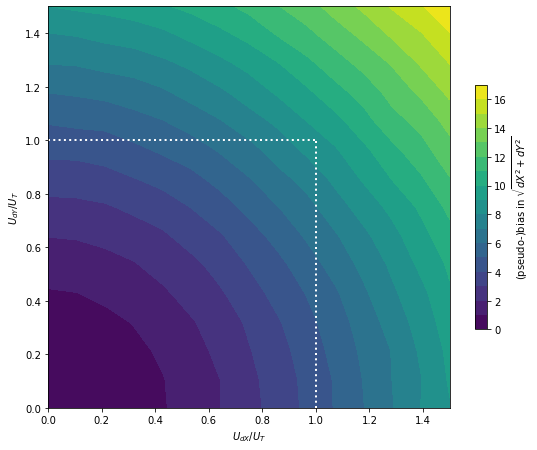

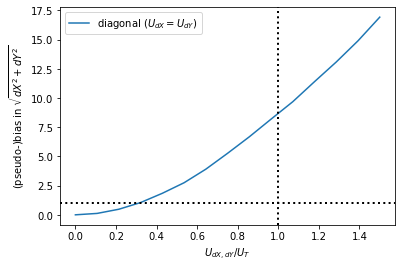

In [10]:
# 2D plot
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(1,1,1, aspect=1)
c = ax.contourf(sigs_ux / sig_t, sigs_uy / sig_t, bias_V,  levels=np.arange(0,round(bias_V.max())+1,))
ax.set_xlabel('$U_{dX} / U_T$')
ax.set_ylabel('$U_{dY} / U_T$')
ax.plot([0.,1.],[1.,1.],lw=2,ls=':',c='white')
ax.plot([1.,1.],[0.,1.],lw=2,ls=':',c='white')
plt.colorbar(c, shrink=0.5).set_label('(pseudo-)bias in ' + r'$\sqrt{dX^2+dY^2}$')
plt.show()

# 1D plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1, )
ax.plot(sigs_ux / sig_t, bias_V.diagonal(), label=r'diagonal ($U_{dX} = U_{dY}$)')
ax.set_xlabel('$U_{dX,dY} / U_T$')
ax.set_ylabel('(pseudo-)bias in ' + r'$\sqrt{dX^2+dY^2}$')
ax.axvline(x=1,lw=2,ls=':',c='black')
ax.axhline(y=1,lw=2,ls=':',c='black')
ax.legend()
plt.show()


As expected, the pseudo-bias is small when the uncertainties in observing $dX$ and $dY$ are small, and it increases with increasing observation uncertainty. In our example, it takes values larger than 1 already when the the observation uncertainty is about 1/3 of the true variability of $tX$ and $tY$, although the mean magnitude of $tX$ and $tY$ probably also play a major role in the magnitude of the pseudo-bias (not shown).

## Implication for trend analysis

We create an artificial timeseries of $tX$ and $tY$, with some trends. $tX$ and $tY$ are the mean values of two distributions whose standard deviation $\sigma_t$ stays constant.

In [11]:
years = np.arange(1979,2021).astype('int')
aX = np.ones(len(years)) * (years - years[0]) * 0.05 + 0.5
aY = np.ones(len(years)) * (years - years[0]) * 0.09 - 1.0
N = 5000

Consider an un-biased obsevation system with uncertainties that improve in two jumps (e.g. better satellites). The observation uncertainty is the same for $dX$ and $dY$. 

In [12]:
sig_os = 4 * np.ones(len(years))
sig_os[(years>=1987)*(years<2002)]  = 3
sig_os[(years>=2002)]  = 2

Go through the years, simulate true and observed distribution of the components, then compute the speeds, finally compute the yearly averaged values of all these quantities.

In [13]:
tX = np.zeros(len(years))
tY = np.zeros(len(years))
tV = np.zeros(len(years))
oX = np.zeros(len(years))
oY = np.zeros(len(years))
oV = np.zeros(len(years))
for y in range(len(years)):
    # distribution of tXs and tYs
    tXs = rng.standard_normal(N) * 4 + aX[y]
    tYs = rng.standard_normal(N) * 4 + aY[y]
    # corresponding tVs
    tVs = speed(tXs, tYs)
    # simulate the oXs and oYs
    ux = rng.standard_normal(N) * sig_os[y]
    oXs = tXs + ux
    uy = rng.standard_normal(N) * sig_os[y]
    oYs = tYs + uy
    #corresponding oVs
    oVs = speed(oXs, oYs)
    # extract yearly averages
    tX[y] = tXs.mean()
    tY[y] = tYs.mean()
    tV[y] = tVs.mean()
    oX[y] = oXs.mean()
    oY[y] = oYs.mean()
    oV[y] = oVs.mean()

from scipy.stats import linregress
alpha_tV, beta_tV, _, _, _ = linregress(years, tV)
alpha_oV, beta_oV, _, _, _ = linregress(years, oV)

Plotting

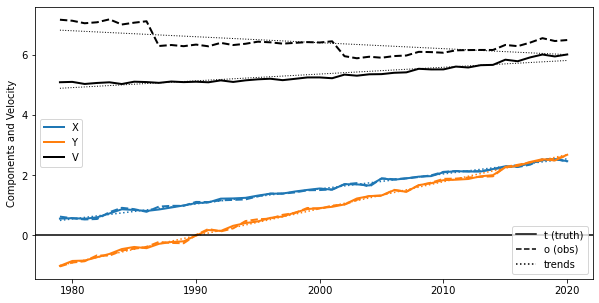

In [14]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.plot(years, tX, label='X', c='C0', lw=2)
ax.plot(years, oX, c='C0', lw=2, ls='--')
ax.plot(years, aX, c='C0', ls=':' )

ax.plot(years, tY, label='Y', c='C1', lw=2)
ax.plot(years, oY, c='C1', lw=2, ls='--')
ax.plot(years, aY, c='C1', ls=':' )

ax.plot(years, tV, 'k-', label='V', lw=2)
ax.plot(years, oV, 'k--', lw=2)
ax.plot(years, alpha_tV*years + beta_tV, 'k:', lw=1)
ax.plot(years, alpha_oV*years + beta_oV, 'k:', lw=1)

ax.axhline(y=0, color='k', ls='-')

line1 = mlines.Line2D([], [], color='k', ls = '-', label='t (truth)')
line2 = mlines.Line2D([], [], color='k', ls = '--', label='o (obs)')
line3 = mlines.Line2D([], [], color='k', ls = ':', label='trends')
sec_leg = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(sec_leg,)

ax.set_ylabel('Components and Speed')
ax.legend(loc='center left')
plt.show()

We observe that the $oX$ and $oY$ follow $tX$ and $tY$: they are un-biased observations of the truth and follow the actual trends.

Converserly, $oV$ is very different from $tV$. First, we observe that $oV$ is systematically larger than $tV$, which is due to the pseudo-bias following the propagation of the observation uncertainty in the non-linear transform from the components to the speed.

In addition, we observe jumps in $oV$. These jumps correspond to the changing observation uncertainties along the timeseries (e.g. technological improvements with better satellites). Note that these jumps are not visible in $oX$ and $oY$: they do not impact the mean observed value (since the observations of components remain un-biased).

The jumps in $oV$ even result in an overall negative trend in observed speed while the trend of the true speed is positive.

## Conclusion
Be cautious with speeds (and generally non-linear transforms) in case of observational uncertainties: they can suffer from pseudo-biases, jumps in timeseries, and lead to erroneous trends. Always first compare vector timeseries in terms of their components.

Ideally we should do trend analysis of $dX$ and $dY$ or of linear transforms from $dX$ and $dY$ (for example projection of the vectors along fixed directions).

## Some thoughts from Andreas

I tried to find an analytical solution to the pseudo-bias, but did not find a quick solution. If looking at the bias (expectation value $E[]$ of the difference in observed and true values) in **squared** velocities, it looks much nicer, maybe this somehow useful/inspires somthing? Disclaimer: this might well be full of misstakes.

$E[oV^2-tV^2] = E[oX^2+oY^2-tX^2-tY^2] = E[tX^2+2tXuX+uX^2+tY^2+2tYuY+uY^2 - tX^2-tY^2]=E[2tXuX+uX^2+2tYuY+uY^2]$

If the uncerenties are independent of the real flow: $E[tXuX]=E[tX]E[uX]$ and since $uX$ unbiased, $E[uX]=0$

In addition $E[uX^2]=VAR(uX)=\sigma_{ux}^2$

Hence $E[oV^2-tV^2]=\sigma_{ux}^2+\sigma_{uy}^2$

I am a bit supprised that this is completely independent of the true/background flow, but can not say exactly why.

The potential use of this is that you can estimate the pseudo bias in the mean squared velocity if you know the measurement uncertainty (as illustrated in the code below, where I used this information to remove the bias). For illustration I plot the sqrt of the bias-corrected mean squared velocities to get everything in the same plot/units, but it should not be confused with the mean velocity I think. 


In [ ]:
tX = np.zeros(len(years))
tY = np.zeros(len(years))
tV = np.zeros(len(years))
tV2 = np.zeros(len(years))
oX = np.zeros(len(years))
oY = np.zeros(len(years))
oV = np.zeros(len(years))
oV2 = np.zeros(len(years))
for y in range(len(years)):
    # distribution of tXs and tYs
    tXs = rng.standard_normal(N) * 4. + aX[y]
    tYs = rng.standard_normal(N) * 4. + aY[y]
    # corresponding tVs
    tVs = velocity(tXs, tYs)
    # simulate the oXs and oYs
    ux = rng.standard_normal(N) * sig_os[y]
    oXs = tXs + ux
    uy = rng.standard_normal(N) * sig_os[y]
    oYs = tYs + uy
    #corresponding oVs
    oVs = velocity(oXs, oYs)
    #oVs2= velocitysqu(oXs, oYs)
    # extract yearly averages
    tX[y] = tXs.mean()
    tY[y] = tYs.mean()
    tV[y] = tVs.mean()
    tV2[y]=np.square(tVs).mean()
    oX[y] = oXs.mean()
    oY[y] = oYs.mean()
    oV[y] = oVs.mean()
    oV2[y]= np.square(oVs).mean()

from scipy.stats import linregress
alpha_tV, beta_tV, _, _, _ = linregress(years, tV)
alpha_oV, beta_oV, _, _, _ = linregress(years, oV)


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)

ax.plot(years, tX, label='X', c='C0', lw=2)
ax.plot(years, oX, c='C0', lw=2, ls='--')
ax.plot(years, aX, c='C0', ls=':' )

ax.plot(years, tY, label='Y', c='C1', lw=2)
ax.plot(years, oY, c='C1', lw=2, ls='--')
ax.plot(years, aY, c='C1', ls=':' )

ax.plot(years, tV, 'k-', label='V', lw=2)
ax.plot(years, oV, 'k--', lw=2)
ax.plot(years, (oV2-2*sig_os**2)**0.5, 'k-.', lw=2)#-var(uX)-var(uY) = bias correction
ax.plot(years, alpha_tV*years + beta_tV, 'k:', lw=1)
ax.plot(years, alpha_oV*years + beta_oV, 'k:', lw=1)

ax.axhline(y=0, color='k', ls='-')

line1 = mlines.Line2D([], [], color='k', ls = '-', label='t (truth)')
line2 = mlines.Line2D([], [], color='k', ls = '--', label='o (obs)')
line3 = mlines.Line2D([], [], color='k', ls = ':', label='trends')
sec_leg = ax.legend(handles=[line1,line2,line3], loc='lower right')
ax.add_artist(sec_leg,)

ax.set_ylabel('Components and Velocity')
ax.legend(loc='center left')
plt.show()
